In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Question 4

In [ ]:
class Conv2D(nn.Module):
  """Module for calculating a forward pass, on init module needs number of channels of input and output"""
  def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1):
    super(Conv2D, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.kernel = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size[0], kernel_size[1]))

  
  def forward(self, input_batch):
    """Forward pass for kernel, using a reshapment an unrolling 2D convolution"""
    batch, in_channels, height, width = input_batch.size()
    out_width = (width - self.kernel_size[1] + self.padding * 2 + 1)//self.stride
    out_height = (height - self.kernel_size[0] + self.padding * 2 + 1)//self.stride

    X = F.unfold(input_batch, self.kernel_size, dilation=1, padding=self.padding, stride=self.stride)
    X = X.transpose(1, 2)
      
    X = X.matmul(self.kernel.view(self.kernel.size(0), -1).t())
    X = X.transpose(1, 2)
      
    batch_output = F.fold(X, (out_height, out_width), (1, 1))

    return batch_output

In [ ]:
conv = Conv2D(3, 1)
input_batch = torch.randn(16, 3, 32, 32)
output_batch = conv.forward(input_batch)


In [ ]:
class Conv2DFunc(torch.autograd.Function):
  """
  Custom autograd Functions by subclassing torch.autograd.Function and implementing the forward and backward
  passes which operate on Tensors.
  """
  @staticmethod
  def forward(ctx, input_batch, kernel, kernel_size=(3,3), stride=1, padding=1):
    """
    Tensor containing the input is received as inout and the output is also tensor multiplied by kernel. 
    Ctx is a context object, that caches arbitrary objects for use in the backward pass using the ctx.save_for_backward method.
    """
    # store objects for the backward
    ctx.kernel_size = _pair(kernel_size)
    ctx.padding = _pair(padding)
    ctx.stride = _pair(stride)

    batch, in_channels, height, width = input_batch.size()
    out_width = (width - kernel_size[1] + padding * 2 + 1)//stride
    out_height = (height - kernel_size[0] + padding * 2 + 1)//stride
    print("x",input_batch.shape)
    X = F.unfold(input_batch, kernel_size, dilation=1, padding=padding, stride=stride)

    X = X.transpose(1, 2)
    print("x",X.shape)
    X = X.matmul(kernel.view(kernel.shape[0], -1).t())
    
    print("x",X.shape)

    X = X.transpose(1, 2)
    
    output_batch = F.fold(X, (out_height, out_width), (1, 1))

    ctx.save_for_backward(input_batch, output_batch, kernel)
    print("output_batch",output_batch.shape)

    return output_batch

  @staticmethod
  def backward(ctx, grad_output):
    """
    In the backward pass we receive a Tensor containing the gradient of the loss with respect to the output
    and the gradient of the loss with respect to the input and weights is returned
    """
    # retrieve stored objects
    input_batch, output_batch, kernel = ctx.saved_tensors
    X = F.unfold(input_batch, ctx.kernel_size, dilation=1, padding=ctx.padding, stride=ctx.stride)
 
    transformed_grad_output = grad_output.view(grad_output.shape[0], grad_output.shape[2]* grad_output.shape[3], grad_output.shape[1])
    
    kernel_grad = X.matmul(transformed_grad_output)
    
    input_batch_grad = transformed_grad_output.matmul(kernel.view(kernel.shape[0], -1))
    
    input_batch_grad = input_batch_grad.transpose(1, 2)

    kernel_grad = kernel_grad.view(input_batch.shape[0], kernel.shape[1], kernel.shape[2], kernel.shape[3])
    print(input_batch_grad.shape)
    input_batch_grad = F.fold(input_batch_grad, (input_batch.shape[2], input_batch.shape[3]), (3,3), padding=ctx.padding)
    print(input_batch_grad.shape)
    return input_batch_grad, kernel_grad, None, None

In [ ]:
input_batch = torch.randn(16, 3, 32, 32)
out_channels = 1
in_channels = input_batch.shape[1]
kernel_size = (3,3)
kernel = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size[0], kernel_size[1]))

function = Conv2DFunc.apply
output = function(input_batch, kernel)
loss = (output * 0 + 1).sum()

loss.backward()

x torch.Size([16, 3, 32, 32])
x torch.Size([16, 1024, 27])
x torch.Size([16, 1024, 1])
output_batch torch.Size([16, 1, 32, 32])
torch.Size([16, 27, 1024])
torch.Size([16, 3, 32, 32])


In [ ]:
kernel = torch.randn(27, 1)
kernel.shape[0]

27

# Question 7

In [ ]:
def get_train_val_loader_Q7(batch_size, augment = False):
    """
    Returns trainloader and valloader of the MNIST dataset. 
    In case of data augmentation, only trainloader data is augmented.
    """
    
    
    normalize = transforms.Normalize((0.1307,), (0.3081,))

    if augment:
        transform_train = transforms.Compose([transforms.ToTensor(),
                                              normalize,
                                              transforms.RandomRotation((-2.0,2.0),fill=(1,)),
                                              transforms.RandomAffine(10),
                                              transforms.RandomPerspective(.2)])
    else:
        transform_train = transforms.Compose([transforms.ToTensor(), normalize])
    
    transform_val = transforms.Compose([transforms.ToTensor(), normalize])

    # load the same training data twice. transformations should be applied only to training data, not val data in case of augmentation,
    # so we should split the training data twice in the exact same way to leave validation data untransformed
    train_data = torchvision.datasets.MNIST('/files', train=True, download=True, transform=transform_train)
  
    val_data = torchvision.datasets.MNIST('/files', train=True, download=True, transform=transform_val)

    
    num_train = len(train_data)
    indices = list(range(num_train))


    # shuffle data and separate training and validation data
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[10000:], indices[:10000]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(valid_idx)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, sampler=val_sampler, num_workers=2)
    
    return train_loader, val_loader

        


In [ ]:
def accuracy(model, dataloader, validate=False, criterion=None):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            
            if validate:
                loss = criterion(outputs, labels)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if validate:
        return correct / total, loss.item()
    else:
        return correct / total

""" Training Loop """

def training_Q7(model, optimizer, criterion, trainloader, n_epochs, validate=None):
    # lists for results
    loss_train, loss_val, acc_train, acc_val = [], [], [], []
    
    for epoch in range(n_epochs):
        running_loss = []

        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            # forward + loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward
            loss.backward()

            # update
            optimizer.step()

        #     # loss
        #     running_loss.append(loss.item())

        #     if i % 1000 == 0:  
        #         #print('[%d, %5d]' %(epoch + 1, i))
        #         print('training')

        # loss_train.append(np.mean(running_loss))

        # acc = accuracy(model, trainloader)
        # acc_train.append(acc)
        # print('Epoch ' + str(epoch+1) + ', training accuracy = ' + str(round(acc, 4)) + ', training loss = ' + str(round(loss_train[-1], 4)))  

        if validate:
            acc_validate, loss_validate = accuracy(model, validate, True, criterion)
            acc_val.append(acc_validate)
            loss_val.append(loss_validate)
            print('Validation accuracy = ' + str(round(acc_validate, 4))+', validation loss = ' + str(round(loss_val[-1], 4)) + '\n')

    
        
    
    if validate:
        return loss_train, acc_train, loss_val, acc_val
    else:
        return loss_train, acc_train

# Question 8

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc    = nn.Linear(576, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:


learning_rate = 0.0001
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()     
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

trainloader, valloader = get_train_val_loader_Q7(16)

loss_train, acc_train, loss_val, acc_val = training_Q7(model, optimizer, criterion, trainloader, 1, valloader)

# Plot the resulting loss over time

plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss', color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show();
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy', color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.show();

Validation accuracy = 0.9541, validation loss = 0.1519



# Question 9 

Data augmentation is applied to the trianing data. The same model is trained on the augmented data.

Validation accuracy = 0.9589, validation loss = 0.0976

Validation accuracy = 0.9718, validation loss = 0.3882

Validation accuracy = 0.9773, validation loss = 0.0176

Validation accuracy = 0.9797, validation loss = 0.0644

Validation accuracy = 0.9813, validation loss = 0.0083

Validation accuracy = 0.9831, validation loss = 0.0168

Validation accuracy = 0.9874, validation loss = 0.002

Validation accuracy = 0.986, validation loss = 0.0037

Validation accuracy = 0.9877, validation loss = 0.4111

Validation accuracy = 0.9878, validation loss = 0.0007

Validation accuracy = 0.9893, validation loss = 0.0756

Validation accuracy = 0.9873, validation loss = 0.0001

Validation accuracy = 0.9891, validation loss = 0.0099

Validation accuracy = 0.9879, validation loss = 0.009

Validation accuracy = 0.99, validation loss = 0.0066

Validation accuracy = 0.9901, validation loss = 0.0003

Validation accuracy = 0.9914, validation loss = 0.0143

Validation accuracy = 0.9916, validation loss = 0.156

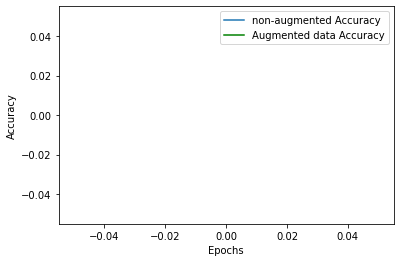

In [ ]:
"""
Let's train the model on the augmented data
"""
# transform train data
trainloader_aug, valloader_aug = get_train_val_loader_Q7(16, augment=True)


learning_rate = 0.0001


model_aug = Net()
model_aug.to(device)

criterion_aug = nn.CrossEntropyLoss()     
optimizer_aug = optim.Adam(model_aug.parameters(), lr = learning_rate)

loss_train_aug, acc_train_aug, loss_val_aug, acc_val_aug = training_Q7(model_aug, optimizer_aug, criterion_aug, trainloader_aug, 20, valloader_aug)
loss_train, acc_train, loss_val, acc_val = training_Q7(model, optimizer, criterion, trainloader, 20, valloader)

print(acc_val_aug)
print(acc_val)

plt.plot(acc_train, label='non-augmented Accuracy')
plt.plot(acc_train_aug, label='Augmented data Accuracy', color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.show();




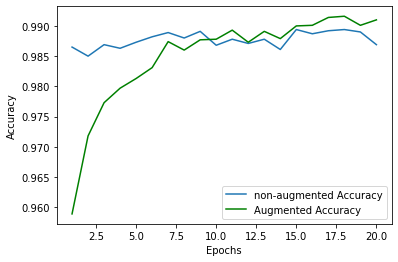

In [ ]:
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], acc_val, label='non-augmented Accuracy')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], acc_val_aug, label='Augmented Accuracy', color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.show();

In [ ]:
"""
Reporting accuracies on test data for model trained on normal data and model trained on augmented
"""
# get test data and test_loader
normalize = transforms.Normalize((0.1307,), (0.3081,))

test_data = torchvision.datasets.MNIST('/files', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=2)



# accuracy for non-augmented data:
test_accuracy = accuracy(model, testloader)
print('For non-augmented data, final accuracy is ' + str(round(test_accuracy, 4)))

# accuracy for augmented data:
test_accuracy_aug = accuracy(model_aug, testloader)
print('For augmented data, final accuracy is ' + str(round(test_accuracy_aug, 4)))



For non-augmented data, final accuracy is 0.9878
For augmented data, final accuracy is 0.9767


# Question 10


# Question 11 


In [ ]:
# just examples
b, c, h, w = 8, 3, 1024, 768

# input tensor
x = torch.randn(b, c, h, w)

# implementing global max and mean with just one line per operation
def global_max(x): return nn.MaxPool2d(x.size()[2:])(x).squeeze()
def global_mean(x): return nn.AvgPool2d(x.size()[2:])(x).squeeze()

y_max = global_max(x)
y_mean = global_mean(x)

# check if size is as desired!
print(y_max.size())
print(y_mean.size())

torch.Size([8, 3])
torch.Size([8, 3])


# Question 12 

In [ ]:
# Downloading and extracting the images
! wget https://dlvu.github.io/data/mnist-varres.tgz
!tar -xvf 'mnist-varres.tgz' 

In [ ]:
normalize = transforms.Normalize((0.1307,), (0.3081,))

# resizing the images and making them have 1 channel rather than 3
transform_train = transforms.Compose([transforms.ToTensor(), normalize, transforms.Resize([28, 28]), transforms.Grayscale(1)]) 

root = 'mnist-varres/train'
train_v = torchvision.datasets.ImageFolder(root, transform = transform_train)

trainset, valset = torch.utils.data.random_split(train_v, [55000, 5000])

# Creating dataloaders 
train_loader_28 = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
val_loader_28 = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
learning_rate = 0.005
model_Q12 = Net()
model_Q12.to(device)

criterion_Q12 = nn.CrossEntropyLoss()     
optimizer_Q12 = optim.Adam(model_Q12.parameters(), lr = learning_rate)

loss_train_Q12, acc_train_Q12, loss_val_Q12, acc_val_Q12 = training_Q7(model_Q12, optimizer_Q12, criterion_Q12, train_loader_28, 2, val_loader_28)

training
training
training
training
Epoch 1, training accuracy = 0.9348, training loss = 0.4193
Validation accuracy = 0.9248, validation loss = 0.2414

training
training
training
training
Epoch 2, training accuracy = 0.9389, training loss = 0.2271
Validation accuracy = 0.9324, validation loss = 0.1635



# Question 14

First the data is sorted based on size. The sorted data is placed in new folders on the drive. After this a custom Dataset class is constructed to get the data from the new folders. Next, a function is defined to create dataloaders from the custom datasets.

In [ ]:
import glob
import numpy as np
from PIL import Image
import numpy as np


def make_folders(instance = 'train'):
    """
    Create new folders for the MNIST images. Folders are separated by size, x and y, and training or test instance
    """
    root = 'mnist-varres/' + instance + '/'
    l = list(range(10))

    data_32, data_48, data_64 = [[],[]], [[],[]], [[],[]]

    for label in l:
        images = glob.glob(root+str(label)+ '/*.png')

        for image in images:
            image = np.asarray(Image.open(image))
            if np.shape(image)[0] == 32:
                data_32[0].append([image])
                data_32[1].append(label)

            elif np.shape(image)[0] == 48:
                data_48[0].append([image])
                data_48[1].append(label)
                
            elif np.shape(image)[0] == 64:
                data_64[0].append([image])
                data_64[1].append(label)
        

    data_32_x, data_32_y = np.asarray(data_32[0]), np.asarray(data_32[1])
    data_48_x, data_48_y = np.asarray(data_48[0]), np.asarray(data_48[1])
    data_64_x, data_64_y = np.asarray(data_64[0]), np.asarray(data_64[1])

    np.save('/content/32_x_' + instance, data_32_x, allow_pickle = True)
    np.save('/content/48_x_' + instance, data_48_x, allow_pickle = True)
    np.save('/content/64_x_' + instance, data_64_x, allow_pickle = True)

    np.save('/content/32_y_' + instance, data_32_y, allow_pickle = True)
    np.save('/content/48_y_' + instance, data_48_y, allow_pickle = True)
    np.save('/content/64_y_' + instance, data_64_y, allow_pickle = True)


make_folders()
make_folders('test')

In [ ]:
class VarDataset(Dataset):
    """
    Custom dataset class
    """

    def __init__(self, size = 32, instance = 'train'):
        file_x = '/content/' + str(size) + '_x_' + instance + '.npy'
        file_y = '/content/' + str(size) + '_y_' + instance + '.npy'
        x = np.load(file_x, allow_pickle = True)
        y = np.load(file_y, allow_pickle = True)
        
        x = x.astype('float32')

        self.n_samples = np.shape(x)[0]

        self.x_data = torch.from_numpy(x) 
        self.y_data = torch.from_numpy(y) 
        self.y_data = self.y_data.to(torch.long)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

data_32_train_full = VarDataset(32)
data_48_train_full = VarDataset(48)
data_64_train_full = VarDataset(64)

data_32_test = VarDataset(32, 'test')
data_48_test = VarDataset(48, 'test')
data_64_test = VarDataset(64, 'test')



In [ ]:
import math

def get_data_loaders_Q14(dataset, batch_size):
    split = math.floor(len(dataset)/10) * 8

    trainset, valset = torch.utils.data.random_split(dataset, [split, len(dataset)-split])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
    valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = True, num_workers = 2)

    return trainloader, valloader

data_32_train, data_32_val = get_data_loaders_Q14(data_32_train_full, 16)
data_48_train, data_48_val = get_data_loaders_Q14(data_48_train_full, 16)
data_64_train, data_64_val = get_data_loaders_Q14(data_64_train_full, 16)



In [ ]:
def training_Q14(model, optimizer, criterion, trainloaders, n_epochs, valloaders):
    # lists for results
    loss_train, acc_train, loss_val, acc_val = [], [], [], []

    for epoch in range(n_epochs):
        running_loss = []
        total_train = 0
        correct_train = 0

        # go through list of trainloaders
        for trainloader in trainloaders:

            for i, data in enumerate(trainloader):
                inputs, labels = data[0].to(device), data[1].to(device)
                total_train += labels.size(0)

                optimizer.zero_grad()

                # forward + loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                with torch.no_grad():
                    _, predicted = torch.max(outputs.data, -1)
                    correct_train += (predicted == labels).sum().item()

                # backward
                loss.backward()

                # update
                optimizer.step()

                # loss
                running_loss.append(loss.item())
                if i % 500 == 0:
                    print('Training.....')

            

        loss_train.append(np.mean(running_loss))
        acc_train.append(correct_train/ total_train)

        print('Epoch ' + str(epoch+1) + ', training accuracy = ' + str(round(acc_train[-1], 4)) + ', training loss = ' + str(round(loss_train[-1], 4)))  
        

        """ Get validation loss and accuracy """
        total_val_correct = 0
        total_val = 0
        running_val_loss = []
        for valloader in valloaders:
            for data in valloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                total_val += labels.size(0)

                with torch.no_grad():
                    outputs = model(inputs)
                    labels = labels.to(torch.long)
                    #loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, -1)
                    total_val_correct += (predicted == labels).sum().item()
                    #running_val_loss.append(loss.item())


        #loss_val.append(np.mean(running_val_loss))    
        acc_val.append(total_val_correct/ total_val)
        #print('Validation accuracy = ' + str(round(acc_val[-1], 4))+', validation loss = ' + str(round(loss_val[-1], 4)) + '\n')
        print('Validation accuracy = ' + str(round(acc_val[-1], 4))+'\n')

    return loss_train, acc_train, loss_val, acc_val
 

# Question 15

In [ ]:
""" Count parameters of the CNN of the previous section """
model = Net()

def get_n_params(model):
    params = 0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        params += nn
    return params

get_n_params(model)

29066

In [ ]:
def count_params(N):
    """
    Function that calculates the number of parameters for the new CNN model given N
    """
    return 16*10 + 32*(1+16*9) + N*(1+32*9) + (1+N)*10

# Trial-and-error shows that N=81 is the best choice
print(count_params(80))
print(count_params(81))
print(count_params(82))

28730
29029
29328


In [ ]:
""" Defining the new CNN """

class Net_N(nn.Module):
    def __init__(self, N, pool_type='max'):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, N, 3, 1, 1)
        self.lin = nn.Linear(N, 10)
        self.pool_type = pool_type

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        if self.pool_type == 'max':
            x = self.lin(nn.MaxPool2d(x.size()[2:])(x).squeeze())
        elif self.pool_type == 'mean':
            x = self.lin(nn.AvgPool2d(x.size()[2:])(x).squeeze())

        return x




# Question 16

In [ ]:
# create CNN (global max)
model_max = Net_N(81)
model_max.to(device)

learning_rate = 0.001
criterion_max = nn.CrossEntropyLoss()     
optimizer_max = optim.Adam(model_max.parameters(), lr = learning_rate)

# create lists of the dataloaders with different image sizes
trainloaders = [data_32_train, data_48_train, data_64_train]
valloaders = [data_32_val, data_48_val, data_64_val]


# train the model
loss_train, acc_train, loss_val, acc_val = training_Q14(model_max, optimizer_max, criterion_max, trainloaders, 3, valloaders)

Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Epoch 1, training accuracy = 0.9157, training loss = 0.2965
Validation accuracy = 0.9568

Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Epoch 2, training accuracy = 0.9704, training loss = 0.0996
Validation accuracy = 0.9749

Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Epoch 3, training accuracy = 0.9762, training loss = 0.0772
Validation accuracy = 0.9664



In [ ]:
""" Now comparing to a CNN with a global mean! """
# create CNN (global man)
model_mean = Net_N(81, pool_type='mean')
model_mean.to(device)

learning_rate = 0.001
criterion_mean = nn.CrossEntropyLoss()     
optimizer_mean = optim.Adam(model_mean.parameters(), lr = learning_rate)

# create lists of the dataloaders with different image sizes
trainloaders = [data_32_train, data_48_train, data_64_train]
valloaders = [data_32_val, data_48_val, data_64_val]


# train the model
loss_train, acc_train, loss_val, acc_val = training_Q14(model_mean, optimizer_mean, criterion_mean, trainloaders, 3, valloaders)

Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Epoch 1, training accuracy = 0.9151, training loss = 0.2867
Validation accuracy = 0.9638

Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Epoch 2, training accuracy = 0.9749, training loss = 0.0927
Validation accuracy = 0.9823

Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Training.....
Epoch 3, training accuracy = 0.9813, training loss = 0.069
Validation accuracy = 0.981



Looks like a global mean performs better! Next we'll compare it to the original CNN network where we resize all images to shape 64x64. 

# Question 17


In [ ]:
def accuracy(model, dataloader, validate=False, criterion=None):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            
            if validate:
                loss = criterion(outputs, labels)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if validate:
        return correct / total, loss.item()
    else:
        return correct / total

""" Training Loop """

def training_Q17(model, optimizer, criterion, trainloader, n_epochs, validate=None):
    # lists for results
    loss_train, loss_val, acc_train, acc_val = [], [], [], []
    
    for epoch in range(n_epochs):
        running_loss = []

        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            # forward + loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward
            loss.backward()

            # update
            optimizer.step()

            # loss
            running_loss.append(loss.item())

            if i % 1000 == 0:  
                #print('[%d, %5d]' %(epoch + 1, i))
                print('training')

        loss_train.append(np.mean(running_loss))

        acc = accuracy(model, trainloader)
        acc_train.append(acc)
        print('Epoch ' + str(epoch+1) + ', training accuracy = ' + str(round(acc, 4)) + ', training loss = ' + str(round(loss_train[-1], 4)))  

        if validate:
            acc_validate, loss_validate = accuracy(model, validate, True, criterion)
            acc_val.append(acc_validate)
            loss_val.append(loss_validate)
            print('Validation accuracy = ' + str(round(acc_validate, 4))+', validation loss = ' + str(round(loss_val[-1], 4)) + '\n')

    
        
    
    if validate:
        return loss_train, acc_train, loss_val, acc_val
    else:
        return loss_train, acc_train

In [ ]:
""" CNN with input all resized to 28x28 """ 

learning_rate = 0.001
model_resized = Net()
model_resized.to(device)

criterion_resized = nn.CrossEntropyLoss()     
optimizer_resized = optim.Adam(model_resized.parameters(), lr = learning_rate)

loss_train, acc_train, loss_val, acc_val = training_Q17(model_resized, optimizer_resized, criterion_resized, train_loader_28, 5, val_loader_28)



In [ ]:
""" CNN with varied resolution input """

learning_rate = 0.001
model_var_N = Net_N(81, 'mean')
model_var_N.to(device)

criterion_var_N = nn.CrossEntropyLoss()     
optimizer_var_N = optim.Adam(model_var_N.parameters(), lr = learning_rate)

trainloaders = [data_32_train, data_48_train, data_64_train]
valloaders = [data_32_val, data_48_val, data_64_val]


loss_train, acc_train, loss_val, acc_val = training_Q14(model_var_N, optimizer_var_N, criterion_var_N, trainloaders, 5, valloaders)



In [ ]:
""" 
Deeper CNN with varied resolution input 
This one has an extra convolution layer and an extra maxpooling layer.

"""
 

class Net_M(nn.Module):
    def __init__(self, N, M, pool_type='max'):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, N, 3, 1, 1)
        self.conv4 = nn.Conv2d(N, M, 3, 1, 1)
        self.lin = nn.Linear(M, 10)
        self.pool_type = pool_type

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        if self.pool_type == 'max':
            x = self.lin(nn.MaxPool2d(x.size()[2:])(x).squeeze())
        elif self.pool_type == 'mean':
            x = self.lin(nn.AvgPool2d(x.size()[2:])(x).squeeze())

        return x

"""
N and M are chosen such that the network has rougly the same number of weights as before. 
"""
N = 46
M = 26

def calc(N, M):
    count = 16*10 + 32*(16*3*3+1) + N*(32*3*3+1) + M*(N*3*3+1) + 10*(M+1)
    return count

print(calc(N, M))

In [ ]:
learning_rate = 0.001
model_var = Net_M(46, 26, 'mean')
model_var.to(device)

criterion_var = nn.CrossEntropyLoss()     
optimizer_var = optim.Adam(model_var.parameters(), lr = learning_rate)

trainloaders = [data_32_train, data_48_train, data_64_train]
valloaders = [data_32_val, data_48_val, data_64_val]


loss_train, acc_train, loss_val, acc_val = training_Q14(model_var, optimizer_var, criterion_var, trainloaders, 5, valloaders)



In [ ]:
""" Getting test data to resize everything to 28x28 """ 

normalize = transforms.Normalize((0.1307,), (0.3081,))

# resizing the images and making them have 1 channel rather than 3
transform_test = transforms.Compose([transforms.ToTensor(), normalize, transforms.Resize([28, 28]), transforms.Grayscale(1)]) 

root = 'mnist-varres/test'
testset = torchvision.datasets.ImageFolder(root, transform = transform_test)

# Creating dataloader
testloader_28 = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)


""" Getting test data separated in 3 folders based on resolution """

# creating datasets
data_32_test = VarDataset(32, 'test')
data_48_test = VarDataset(48, 'test')
data_64_test = VarDataset(64, 'test')

# creating dataloaders
testloader_32 = torch.utils.data.DataLoader(data_32_test, batch_size =32, shuffle=True, num_workers=2)
testloader_48 = torch.utils.data.DataLoader(data_48_test, batch_size =32, shuffle=True, num_workers=2)
testloader_64 = torch.utils.data.DataLoader(data_64_test, batch_size =32, shuffle=True, num_workers=2)


In [ ]:
""" Testing the models """ 

def test_accuracy_Q17(model, testloaders):
    """
    Second parameter requires a list of testloaders (may contain just one testloader)
    """

    total = 0 
    correct = 0 

    for testloader in testloaders:
        for i, data in enumerate(testloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            total += labels.size(0)

            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, -1)
                correct += (predicted == labels).sum().item()
    
    print('Accuracy on test set = ' + str(round(correct/total, 4)))


# testing resized input CNN
print('For the network with input resized to 28x28: ')
test_accuracy_Q17(model_resized, [testloader_28])

testloaders_var = [testloader_32, testloader_48, testloader_64]

print('\nFor the network with varied input (Q16):')
test_accuracy_Q17(model_var_N, testloaders_var)

print('\nFor the deeper network with varied input (Q17):')
test_accuracy_Q17(model_var, testloaders_var)